In [ ]:
import os 
import pandas as pd 
# Global parameters
#root folder
#os.chdir("/content/drive/MyDrive/Thesis/")
root_folder='/home/lowie'
data_folder_name='/data/'
glove_filename='glove.6B.100d.txt'

# Variable for data directory
DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
glove_path = os.path.abspath(os.path.join(DATA_PATH, glove_filename))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# We just need to run this code once, the function glove2word2vec saves the Glove embeddings in the word2vec format 
# that will be loaded in the next section
from gensim.scripts.glove2word2vec import glove2word2vec

#glove_input_file = glove_filename
word2vec_output_file = glove_filename+'.word2vec'
glove2word2vec("/content/drive/MyDrive/Thesis/Models/Replicated models /Simple models /CNN/glove.6B.100d.txt", word2vec_output_file)

(400000, 100)

In [ ]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
word2vec_output_file = glove_filename+'.word2vec'
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)


In [ ]:
class Word2VecVectorizer:
  def __init__(self, model):
    self.word_vectors = model

  def fit(self, data):
    pass

  def transform(self, data):
    # determine the dimensionality of vectors
    v = self.word_vectors.get_vector('king')
    self.D = v.shape[0]

    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.split()
      vecs = []
      m = 0
      for word in tokens:
        try:
          # throws KeyError if word not found
          vec = self.word_vectors.get_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    return X


  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

In [ ]:
vectorizer = Word2VecVectorizer(model)

In [ ]:
#import os 
#os.chdir("/content/drive/MyDrive/Thesis/Data/Filled Datasets/Second dataset (Kaggle)/Preprocessed/")
coaid = pd.read_csv("/content/drive/MyDrive/Thesis/Data/Filled Datasets/Preprocessed All/Added Claim News text/textcols_tweets_newstext_added_preprocessed.csv",keep_default_na=False)
covid = pd.read_csv("/content/drive/MyDrive/Thesis/Data/Filled Datasets/Second dataset (Kaggle)/Preprocessed/combined_train_val.csv")

In [ ]:
coaid = coaid.sample(n=10000) #for time issues, takes too long for entire dataset 

Clustering

In [ ]:
def cluster_text(text):
    vectorizer = Word2VecVectorizer(model)    
    X = vectorizer.fit_transform(text)

    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans
    Sum_of_squared_distances = []
    K = range(2,10)
    for k in K:
       km = KMeans(n_clusters=k, max_iter=200, n_init=10)
       km = km.fit(X)
       Sum_of_squared_distances.append(km.inertia_)
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

    print('How many clusters do you want to use?')
    true_k = int(input())
    model_k = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
    model_k.fit(X)

    labels=model_k.labels_
    clusters=pd.DataFrame(list(zip(text,labels)),columns=['title','cluster'])
    #print(clusters.sort_values(by=['cluster']))

    for i in range(true_k):
        print(clusters[clusters['cluster'] == i])
        
    return clusters

**COAID DATASET**

In [ ]:
txt = coaid['text']

In [ ]:
txt_list = list(txt)

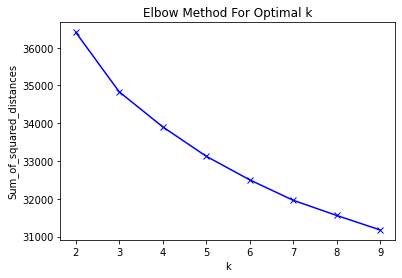

How many clusters do you want to use?
9
                                                  title  cluster
3     symptom based strategy discontinue isolation p...        0
21    given social distancing spaced separated desks...        0
24                             outfield media virus via        0
26    news oz nitric oxide investigated covid treatm...        0
27    sounds promising response fight covid first de...        0
...                                                 ...      ...
9975  best available evidence supports physical dist...        0
9980  interim guidance communities faith joke cdc ta...        0
9981  non urgent emergent healthcare services diagno...        0
9990  cme ce online training designed healthcare pro...        0
9993   new diagnostic predict covid without testing via        0

[1179 rows x 2 columns]
                                                  title  cluster
7     mutations says cov offer insights virus evolution        1
15    researchers identif

In [ ]:
import numpy as np
clusters = cluster_text(txt_list)

In [ ]:
clusters = clusters.rename(columns={"title": "text"})
clusters

,text,cluster
0,medical societies issue bold statement physici...,4
1,hhs delivers funding expand testing capacity s...,4
2,going trash cuomocuomo administration rejected...,4
3,symptom based strategy discontinue isolation p...,0
4,wall street journal news alertfirst person to ...,3
...,...,...
9995,signed wealth management help understand new r...,4
9996,sorry loss grief,8
9997,caring children multisystem inflammatorysyndrome,8
9998,deaths under reported article shows count leas...,2


In [ ]:
df0_coaid = clusters.loc[clusters['cluster'] == 0]
df1_coaid = clusters.loc[clusters['cluster'] == 1]
df2_coaid = clusters.loc[clusters['cluster'] == 2]
df3_coaid = clusters.loc[clusters['cluster'] == 3]
df4_coaid = clusters.loc[clusters['cluster'] == 4]
df5_coaid = clusters.loc[clusters['cluster'] == 5]
df6_coaid = clusters.loc[clusters['cluster'] == 6]
df7_coaid = clusters.loc[clusters['cluster'] == 7]
df8_coaid = clusters.loc[clusters['cluster'] == 8]

In [ ]:
def get_jaccard_sim(str1, str2):
   a = set(str1.split())
   b = set(str2.split())
   c = a.intersection(b)
   return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
def calc_avg_sim(data): 
    total = 0 
    teller = 0
    for i in range(len(data['text'])): 
        if i%100 == 0: 
            print(i)
        for j in range(i+1,len(data['text'])):
            total = total + get_jaccard_sim(data.iloc[i,0],data.iloc[j,0])
            teller = teller + 1 

    avg_sim = total/teller

    return avg_sim

In [ ]:
total = (calc_avg_sim(df0_coaid)+calc_avg_sim(df1_coaid)+calc_avg_sim(df2_coaid)+calc_avg_sim(df3_coaid)+calc_avg_sim(df4_coaid)+calc_avg_sim(df5_coaid)+calc_avg_sim(df6_coaid)+calc_avg_sim(df7_coaid)+calc_avg_sim(df8_coaid))/9
print(total)

0
100
200
300
400
500
600
700
800
900
1000
1100
0
100
200
300
400
500
600
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
0
100
200
300
400
500
600
700
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
0
100
200
300
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
0.04062640487857614


**COVID19 DATASET**

In [ ]:
txt = covid['tweet']

In [ ]:
txt_list = list(txt)

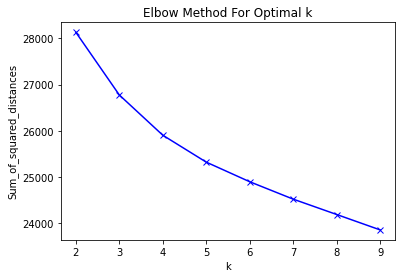

How many clusters do you want to use?
9
                                                  title  cluster
10    take simple daily precautions help prevent spr...        0
24    intriguing possibility mood changes anxiety ma...        0
33    cdc recommends mothers stop breastfeeding boos...        0
48    schools struggling cope lack tests new infecti...        0
67    experts call claims cow dung urine yoga abuse ...        0
...                                                 ...      ...
8502  around k heart attack patients england may mis...        0
8511  study cv risk hydroxychloroquine azithromycin ...        0
8519  researchers claim percent cure rate vs covid p...        0
8532  numerous ongoing clinical trials evaluating po...        0
8554  current understanding spreads mostly person pe...        0

[766 rows x 2 columns]
                                                  title  cluster
3     testing laboratories india th august tests don...        1
18    announced shipped di

In [ ]:
import numpy as np
clusters = cluster_text(txt_list)

In [ ]:
clusters = clusters.rename(columns={"title": "text"})
clusters

,text,cluster
0,cdc currently reports deaths general discrepan...,4
1,states reported deaths small rise last tuesday...,4
2,politically correct woman almost uses pandemic...,5
3,testing laboratories india th august tests don...,1
4,populous states generate large case counts loo...,3
...,...,...
8553,donald trump wrongly claimed new zealand big s...,4
8554,current understanding spreads mostly person pe...,0
8555,nothing screams sat around fuck lockdown quite...,5
8556,bird says covid outbreak control people move,2


In [ ]:
df0_covid = clusters.loc[clusters['cluster'] == 0]
df1_covid = clusters.loc[clusters['cluster'] == 1]
df2_covid = clusters.loc[clusters['cluster'] == 2]
df3_covid = clusters.loc[clusters['cluster'] == 3]
df4_covid = clusters.loc[clusters['cluster'] == 4]
df5_covid = clusters.loc[clusters['cluster'] == 5]
df6_covid = clusters.loc[clusters['cluster'] == 6]
df7_covid = clusters.loc[clusters['cluster'] == 7]
df8_covid = clusters.loc[clusters['cluster'] == 8]

In [ ]:
total_covid = (calc_avg_sim(df0_covid)+calc_avg_sim(df1_covid)+calc_avg_sim(df2_covid)+calc_avg_sim(df3_covid)+calc_avg_sim(df4_covid)+calc_avg_sim(df5_covid)+calc_avg_sim(df6_covid)+calc_avg_sim(df7_covid)+calc_avg_sim(df8_covid))/9
print(total_covid)

0
100
200
300
400
500
600
700
0
100
200
300
400
500
600
700
800
900
1000
1100
0
100
200
300
400
500
600
700
800
900
1000
1100
0
100
200
300
400
500
600
700
800
900
1000
1100
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
0
100
200
300
400
500
600
0
100
200
300
400
500
0.032710275805810665
